# Homework 5 - Optimizers in Deep Learning

Try the following optimizers:

# Gradient Descent

In this section we are going to introduce the basic concepts underlying *gradient descent*.
Although it is rarely used directly in deep learning, an understanding of gradient descent is key to understanding stochastic gradient descent algorithms.
For instance, the optimization problem might diverge due to an overly large learning rate. This phenomenon can already be seen in gradient descent. Likewise, preconditioning is a common technique in gradient descent and carries over to more advanced algorithms.
Let's start with a simple special case.


## One-Dimensional Gradient Descent

Gradient descent in one dimension is an excellent example to explain why the gradient descent algorithm may reduce the value of the objective function. Consider some continuously differentiable real-valued function $f: \mathbb{R} \rightarrow \mathbb{R}$. Using a Taylor expansion we obtain

$$f(x + \epsilon) = f(x) + \epsilon f'(x) + \mathcal{O}(\epsilon^2).$$

That is, in first-order approximation $f(x+\epsilon)$ is given by the function value $f(x)$ and the first derivative $f'(x)$ at $x$. It is not unreasonable to assume that for small $\epsilon$ moving in the direction of the negative gradient will decrease $f$. To keep things simple we pick a fixed step size $\eta > 0$ and choose $\epsilon = -\eta f'(x)$. Plugging this into the Taylor expansion above we get

$$f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x)).$$

If the derivative $f'(x) \neq 0$ does not vanish we make progress since $\eta f'^2(x)>0$. Moreover, we can always choose $\eta$ small enough for the higher-order terms to become irrelevant. Hence we arrive at

$$f(x - \eta f'(x)) \lessapprox f(x).$$

This means that, if we use

$$x \leftarrow x - \eta f'(x)$$

to iterate $x$, the value of function $f(x)$ might decline. Therefore, in gradient descent we first choose an initial value $x$ and a constant $\eta > 0$ and then use them to continuously iterate $x$ until the stop condition is reached, for example, when the magnitude of the gradient $|f'(x)|$ is small enough or the number of iterations has reached a certain value.

For simplicity we choose the objective function $f(x)=x^2$ to illustrate how to implement gradient descent. Although we know that $x=0$ is the solution to minimize $f(x)$, we still use this simple function to observe how $x$ changes.


In [1]:
%matplotlib inline
import numpy as np
import torch
import matplotlib.pyplot as plt

In [2]:
def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

In [10]:
def gd(eta, f_grad):
    x = 10.0 # set initial value
    results = []
    # Tips: try to finish gd update for 10 epoches
    for epoch in range(1, 11):
        gradient = f_grad(x)
        x -= eta * gradient
        results.append( x)

        print(f'epoch {epoch}, x: {x:f}')

    return results

results = gd(0.2, f_grad)
results

epoch 1, x: 6.000000
epoch 2, x: 3.600000
epoch 3, x: 2.160000
epoch 4, x: 1.296000
epoch 5, x: 0.777600
epoch 6, x: 0.466560
epoch 7, x: 0.279936
epoch 8, x: 0.167962
epoch 9, x: 0.100777
epoch 10, x: 0.060466


[6.0,
 3.5999999999999996,
 2.1599999999999997,
 1.2959999999999998,
 0.7775999999999998,
 0.46655999999999986,
 0.2799359999999999,
 0.16796159999999993,
 0.10077695999999996,
 0.06046617599999997]

The progress of optimizing over $x$ can be plotted as follows.

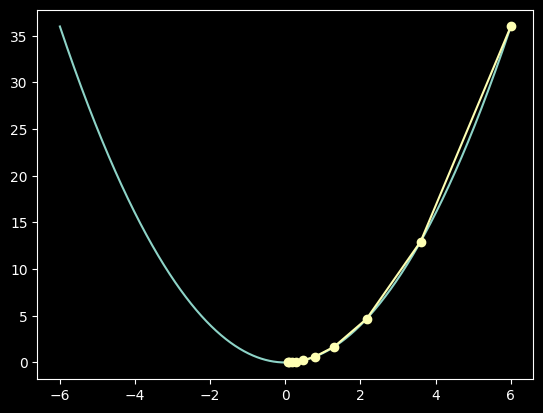

In [11]:
def plot(X, Y=None, xlabel=None, ylabel=None, legend=[], xlim=None,
        ylim=None, xscale='linear', yscale='linear',
        fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """Plot data points."""

    def has_one_axis(X):  # True if `X` (tensor or list) has 1 axis
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X): X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)

    if axes is None: axes = plt.gca()
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        axes.plot(x,y,fmt) if len(x) else axes.plot(y,fmt)

def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])
    
show_trace(results, f)

### Learning Rate

The learning rate $\eta$ can be set by the algorithm designer. If we use a learning rate that is too small, it will cause $x$ to update very slowly, requiring more iterations to get a better solution. To show what happens in such a case, consider the progress in the same optimization problem for $\eta = 0.05$. As we can see, even after 10 steps we are still very far from the optimal solution.


epoch 1, x: 9.000000
epoch 2, x: 8.100000
epoch 3, x: 7.290000
epoch 4, x: 6.561000
epoch 5, x: 5.904900
epoch 6, x: 5.314410
epoch 7, x: 4.782969
epoch 8, x: 4.304672
epoch 9, x: 3.874205
epoch 10, x: 3.486784


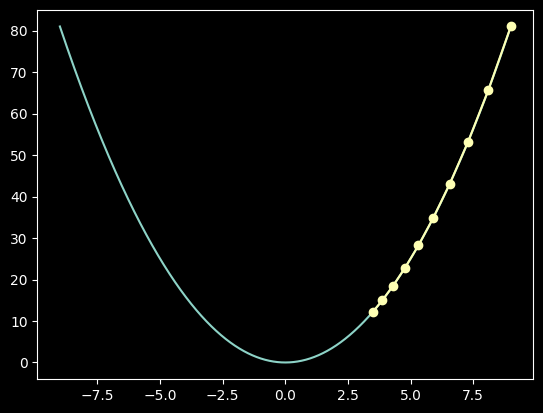

In [12]:
# Tips: try to plot fig with lr = 0.05
results = gd(eta=0.05, f_grad=f_grad)
show_trace(results, f)


Conversely, if we use an excessively high learning rate, $\left|\eta f'(x)\right|$ might be too large for the first-order Taylor expansion formula. That is, the term $\mathcal{O}(\eta^2 f'^2(x))$ in :eqref:`gd-taylor-2` might become significant. In this case, we cannot guarantee that the iteration of $x$ will be able to lower the value of $f(x)$. For example, when we set the learning rate to $\eta=1.1$, $x$ overshoots the optimal solution $x=0$ and gradually diverges.

epoch 1, x: -12.000000
epoch 2, x: 14.400000
epoch 3, x: -17.280000
epoch 4, x: 20.736000
epoch 5, x: -24.883200
epoch 6, x: 29.859840
epoch 7, x: -35.831808
epoch 8, x: 42.998170
epoch 9, x: -51.597804
epoch 10, x: 61.917364


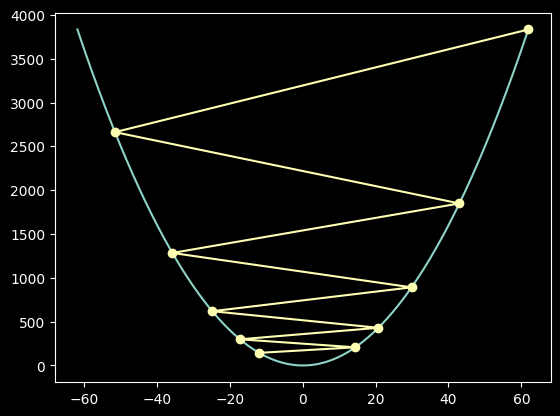

In [13]:
# Tips: try to plot fig with lr = 1.1
results = gd(eta=1.1, f_grad=f_grad)
show_trace(results, f)

### Local Minima

To illustrate what happens for nonconvex functions consider the case of $f(x) = x \cdot \cos(cx)$ for some constant $c$. This function has infinitely many local minima. Depending on our choice of the learning rate and depending on how well conditioned the problem is, we may end up with one of many solutions. The example below illustrates how an (unrealistically) high learning rate will lead to a poor local minimum.


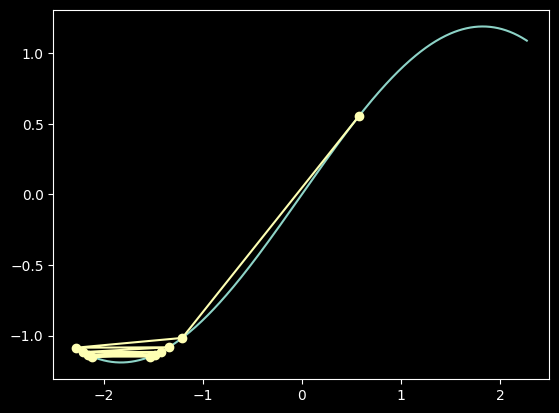

In [16]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Tips: objective function
    return x * torch.cos(c * x)

def f_grad(x):  
    # Tips: try to compute the gradient
    return torch.autograd.grad(f(x), x)[0]

def gd(eta, f_grad):
    x = torch.tensor(10.0, requires_grad=True)  # set initial value
    results = []

    # Iterate for 10 epochs
    for epoch in range(1, 11):
        gradient = f_grad(x)  # Compute the gradient at the current point
        x = x - eta * gradient  # Update x using the gradient descent update rule
        results.append(x.item())  # Store the current value of x

    return results

# Tips: try to plot fig with learning rate = 2
results = gd(2, f_grad)
show_trace(results, f)

# Stochastic Gradient Descent

In earlier chapters we kept using stochastic gradient descent in our training procedure, however, without explaining why it works.
To shed some light on it,
we just described the basic principles of gradient descent.
In this section, we go on to discuss
*stochastic gradient descent* in greater detail.


## Stochastic Gradient Updates

In deep learning, the objective function is usually the average of the loss functions for each example in the training dataset.
Given a training dataset of $n$ examples,
we assume that $f_i(\mathbf{x})$ is the loss function
with respect to the training example of index $i$,
where $\mathbf{x}$ is the parameter vector.
Then we arrive at the objective function

$$f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n f_i(\mathbf{x}).$$

The gradient of the objective function at $\mathbf{x}$ is computed as

$$\nabla f(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}).$$

If gradient descent is used, the computational cost for each independent variable iteration is $\mathcal{O}(n)$, which grows linearly with $n$. Therefore, when the  training dataset is larger, the cost of gradient descent for each iteration will be higher.

Stochastic gradient descent (SGD) reduces computational cost at each iteration. At each iteration of stochastic gradient descent, we uniformly sample an index $i\in\{1,\ldots, n\}$ for data examples at random, and compute the gradient $\nabla f_i(\mathbf{x})$ to update $\mathbf{x}$:

$$\mathbf{x} \leftarrow \mathbf{x} - \eta \nabla f_i(\mathbf{x}),$$

where $\eta$ is the learning rate. We can see that the computational cost for each iteration drops from $\mathcal{O}(n)$ of the gradient descent to the constant $\mathcal{O}(1)$. Moreover, we want to emphasize that the stochastic gradient $\nabla f_i(\mathbf{x})$ is an unbiased estimate of the full gradient $\nabla f(\mathbf{x})$ because

$$\mathbb{E}_i \nabla f_i(\mathbf{x}) = \frac{1}{n} \sum_{i = 1}^n \nabla f_i(\mathbf{x}) = \nabla f(\mathbf{x}).$$

This means that, on average, the stochastic gradient is a good estimate of the gradient.

Now, we will compare it with gradient descent by adding random noise with a mean of 0 and a variance of 1 to the gradient to simulate a stochastic gradient descent.


In [17]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  
    # Tips: try to compute the gradient
    grad_x1 = 2 * x1  # Partial derivative of f with respect to x1
    grad_x2 = 4 * x2  # Partial derivative of f with respect to x2
    return grad_x1, grad_x2

In [18]:
def sgd(x1, x2, s1, s2, f_grad):
    # `s1` and `s2` are internal state variables that will be used in Momentum, adagrad, RMSProp
    # Tips: try to finish Stochastic Gradient Descent
        
    eta = 0.1 # Learning rate
    epsilon = 1e-6  # Small constant to avoid division by zero

    # Compute gradients
    grad_x1, grad_x2 = f_grad(x1, x2)

    # Update squared gradient accumulators
    s1 += grad_x1 ** 2
    s2 += grad_x2 ** 2

    # Compute adaptive learning rates
    eta_x1 = eta / np.sqrt(s1 + epsilon)
    eta_x2 = eta / np.sqrt(s2 + epsilon)

    # Update parameters
    x1 -= eta_x1 * grad_x1
    x2 -= eta_x2 * grad_x2

    return x1, x2, s1, s2

In [19]:
def train_2d(trainer, steps=20, f_grad=None):
    # Optimize a 2D objective function with a customized trainer.

    # initial values
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        # Tips: try to train by using your sgd
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        results.append((x1, x2))
    print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')
    return results

def show_trace_2d(f, results):
    # Show the trace of 2D variables during optimization.
    # results is the update information during sgd training

    plt.plot(*zip(*results), '-o', color='#ff7f0e')
    x1, x2 = torch.meshgrid(torch.arange(-5.5, 1.0, 0.1),
                            torch.arange(-3.0, 1.0, 0.1))
    plt.contour(x1, x2, f(x1, x2), colors='#1f77b4')
    plt.xlabel('x1')
    plt.ylabel('x2')

epoch 20, x1: -4.263763, x2: -1.302483


/zhouyuyang/env/miniconda3/envs/dl/lib/python3.8/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


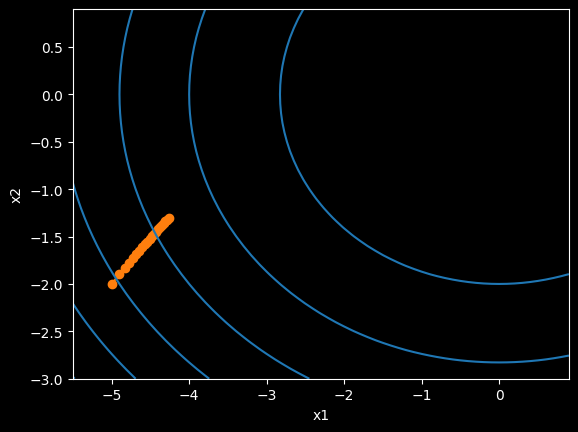

In [20]:
eta = 0.1
lr = 1.0  # Constant learning rate

# Tips: try to plot the training trace with steps=50 with `show_trace_2d`
results = train_2d(sgd, 20, f_grad)
show_trace_2d(f, results)